In [1]:
from math import sqrt
import numpy as np
import matplotlib.path as mpl_path
import pre_processing as pp

In [2]:
class GridPoint():
    def __init__(self, pid: int, x: float, y: float, score: float = 0):
        self._pid = pid
        self._x = x
        self._y = y
        self._score = score
        self._neighbours = []

    def get_coordinates(self):
        return (self._x, self._y)

    @property
    def neighbours(self):
        return self._neighbours

    @neighbours.setter
    def neighbours(self, neighbours: list):
        # print(f"set grid point ({self._x}, {self._y}) neigbours to: {neighbours}")
        self._neighbours = neighbours

    @property
    def pid(self):
        return self._pid

    @property
    def score(self):
        return self._score

    @score.setter
    def score(self, score):
        print(f"set grid point ({round(self._x, 3)}, {round(self._y, 3)}) to score: {round(score, 3)}")
        self._score = score

    def __repr__(self):
        # return (f"{self._pid}")
        return (f"({round(self._x, 3)}, {round(self._y, 3)}, {self._score})")


def generate_point_grid(grid_resolution=20) -> list:
    VAL_RANGE = 2.64
    MIN_VAL = 1.32
    # 1. Generates a point grid G of resolution N_g = n_g x n_g within a bounding box of size [-1.2, 1.2].
    #    Grid size 20 x 20 deemed adequate in papag. et al. We add padding to help neighbour generation
    padded_grid = grid_resolution + 2
    point_grid = []
    point_id = 0
    for i in range(padded_grid, -1, -1):
        point_grid_row = []
        y_coord = i/padded_grid * VAL_RANGE - MIN_VAL
        for j in range(padded_grid+1):
            x_coord = j/padded_grid * VAL_RANGE - MIN_VAL
            point_grid_row.append(GridPoint(point_id, x_coord, y_coord))
            point_id += 1
        point_grid.append(point_grid_row)

    # Sets neighbours for each grid point (not including padding)
    for i in range(1, len(point_grid)-1):
        for j in range(1, len(point_grid)-1):
            neighbour_list = []
            neighbour_list.append(point_grid[i-1][j-1])     # bottom left
            neighbour_list.append(point_grid[i][j-1])       # bottom
            neighbour_list.append(point_grid[i+1][j-1])     # bottom right
            neighbour_list.append(point_grid[i+1][j])       # right
            neighbour_list.append(point_grid[i+1][j+1])     # top right
            neighbour_list.append(point_grid[i][j+1])       # top
            neighbour_list.append(point_grid[i-1][j+1])     # top left
            neighbour_list.append(point_grid[i-1][j])       # left
            point_grid[i][j].neighbours = neighbour_list

    # Flattens point grid list
    point_grid = [item for sublist in point_grid.copy() for item in sublist]

    # Removes padding from output by removing points that were not given neighbours
    point_grid = [x for x in point_grid.copy() if x.neighbours]

    return point_grid


def calculate_score(
        point_grid,
        internal_nodes,
        contour_points: np.array) -> None:
    # 0. Define contour (for finding points inside)
    contour_path = mpl_path.Path(contour_points)

    # For each point in point grid, iterate over internal nodes and calulcate euclidean distance.
    # If point is not in contour, set distance to 1000 (inf)
    for point in point_grid:
        score = 10
        point_coordinates = point.get_coordinates()
        if contour_path.contains_point(point_coordinates):
            for internal_node in internal_nodes:
                distance = sqrt((point_coordinates[0]-internal_node[0])
                                ** 2 + (point_coordinates[1] - internal_node[1])**2)
                if distance < score:
                    score = distance
        point.score = score




In [3]:
pg = generate_point_grid()
sample_points = [(0.0, 0.0)]
contour = pp.create_random_ngon(8)
calculate_score(pg, sample_points, contour)

set grid point (-1.2, 1.2) to score: 10
set grid point (-1.08, 1.2) to score: 10
set grid point (-0.96, 1.2) to score: 10
set grid point (-0.84, 1.2) to score: 10
set grid point (-0.72, 1.2) to score: 10
set grid point (-0.6, 1.2) to score: 10
set grid point (-0.48, 1.2) to score: 10
set grid point (-0.36, 1.2) to score: 10
set grid point (-0.24, 1.2) to score: 10
set grid point (-0.12, 1.2) to score: 10
set grid point (0.0, 1.2) to score: 10
set grid point (0.12, 1.2) to score: 10
set grid point (0.24, 1.2) to score: 10
set grid point (0.36, 1.2) to score: 10
set grid point (0.48, 1.2) to score: 10
set grid point (0.6, 1.2) to score: 10
set grid point (0.72, 1.2) to score: 10
set grid point (0.84, 1.2) to score: 10
set grid point (0.96, 1.2) to score: 10
set grid point (1.08, 1.2) to score: 10
set grid point (1.2, 1.2) to score: 10
set grid point (-1.2, 1.08) to score: 10
set grid point (-1.08, 1.08) to score: 10
set grid point (-0.96, 1.08) to score: 10
set grid point (-0.84, 1.08) t

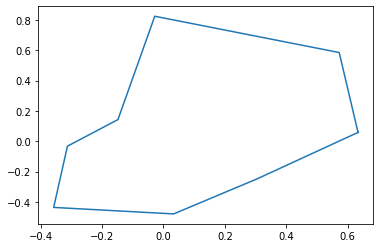

In [4]:
pp.plot_polygon(contour)

In [12]:
import pandas as pd
import tensorflow as tf

# CONSTANTS
LEARNING_RATE = 0.001
EPOCHS = 30
BATCH_SIZE = 64

# Pre-processing
df = pd.read_csv('data/6-gon-mesh-with-internal-nodes-test.csv')
df_no_nan = df.dropna(axis=1, how='all')
df_grouped = df_no_nan.groupby('internal_node_count')
group_count = df_grouped.size()
df_grouped.head(1)


,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,target_edge_length,internal_node_count,a,b,c,d,e,f,g,h
0,1.042776,0.111332,0.169969,0.599310,-0.618421,0.885462,-1.099175,-0.203910,-0.252836,-0.497224,...,0.2,2.0,-0.327421,0.151143,0.278035,-0.106082,NaN,NaN,NaN,NaN
27,0.767687,0.109375,0.393264,1.048289,-0.808304,0.789966,-0.689989,-0.172634,-0.342532,-1.001652,...,0.2,4.0,-0.032001,0.334587,-0.021492,-0.395270,0.292635,-0.050105,-0.112712,-0.070855
37,1.270045,0.143426,0.305413,0.931598,-0.615866,0.610273,-0.716279,-0.103673,-0.573467,-0.997049,...,0.3,1.0,0.036106,0.154542,NaN,NaN,NaN,NaN,NaN,NaN
54,0.892080,-0.075880,0.322600,1.168991,-0.945062,0.704445,-0.660432,-0.363783,-0.135512,-0.694362,...,0.2,3.0,0.053228,0.255221,0.222633,-0.316900,-0.293029,-0.083076,NaN,NaN
